In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, Layer, LSTM, MaxPooling2D, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow as tf

import utils as utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# # For predicting every odd line region, target is 1 channel and flattened, loss is binary cross entropy
# PREDICT_ALTERNATING_LINES = False
# FLATTEN_TARGET = True

# For predicting alternating line regions, target is 3 channels and not flattened, loss in categorical cross entropy
PREDICT_ALTERNATING_LINES = True
FLATTEN_TARGET = False

GS1_DATA_DIRNAME = '/home/saurabh/Documents/dev_2/iamdb'
FARM_DATA_DIRNAME = '/home/sergeyk/work/iamdb'

In [3]:
DATA_DIRNAME = Path(GS1_DATA_DIRNAME)

crop_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped').glob('*.jpg')))
gt_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped-gt').glob('*.png')))

print('Number of samples:', len(crop_filenames))

NUM_LABELS = 2
RESIZE_SCALE_FACTOR = 0.5

X = []
Y = []
for ind in range(len(crop_filenames)):
    name = crop_filenames[ind].stem
    image = cv2.imread(str(crop_filenames[ind]), cv2.IMREAD_GRAYSCALE)
    
    gt_filename = DATA_DIRNAME / 'forms-cropped-gt' / f'{name}.png'
    gt_image = cv2.imread(str(gt_filename), cv2.IMREAD_GRAYSCALE)
    
    # only have three labels: background, odd lines, even lines
    for value in np.unique(gt_image):
        gt_image[gt_image == (value + 1)] = value % 2 + 1

    # get rid of even lines
    if not PREDICT_ALTERNATING_LINES:
        gt_image[gt_image == 2] = 0
    
    image = cv2.resize(image, dsize=None, fx=RESIZE_SCALE_FACTOR, fy=RESIZE_SCALE_FACTOR)
    gt_image = cv2.resize(gt_image, dsize=None, fx=RESIZE_SCALE_FACTOR, fy=RESIZE_SCALE_FACTOR, 
                          interpolation=cv2.INTER_NEAREST)
    
    X.append(1. - image / 255.)
    if PREDICT_ALTERNATING_LINES:
        Y.append(to_categorical(gt_image))
    else:
        Y.append(gt_image)


X_all = np.array(X).astype(np.float32)
Y_all = np.array(Y).astype(np.uint8)

X_all = np.expand_dims(X_all, axis=-1)
if not PREDICT_ALTERNATING_LINES:
    Y_all = np.expand_dims(Y_all, axis=-1)
print(X_all.shape, X_all.dtype, Y_all.shape, Y_all.dtype)

# For training
X_train = X_all[:1000]
X_test = X_all[1000:]
Y_train = Y_all[:1000]
Y_test = Y_all[1000:]

# For overfitting
# X_single = np.repeat(X[0:1], X.shape[0], axis=0)
# Y_single = np.repeat(Y[0:1], Y.shape[0], axis=0)

Number of samples: 1537
(1537, 316, 310, 1) float32 (1537, 316, 310, 3) uint8


In [4]:
def plot(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image[:,:,0], cmap='gray', vmin=0, vmax=max(1, image.max()))
    plt.colorbar()

def hplot(x, y, y_pred=None, title=''):
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(title)
    
    ax1 = fig.add_subplot(131)
    ax1.imshow(x[:,:,0], cmap='gray', vmin=0, vmax=max(1, x.max()))
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(y.reshape(x.shape)[:,:,0], cmap='gray', vmin=0, vmax=max(1, y.max()))
    
    if y_pred is not None:
        ax3 = fig.add_subplot(133)
        ax3.imshow(y_pred.reshape(x.shape)[:,:,0], cmap='gray', vmin=0, vmax=max(1, y_pred.max()))

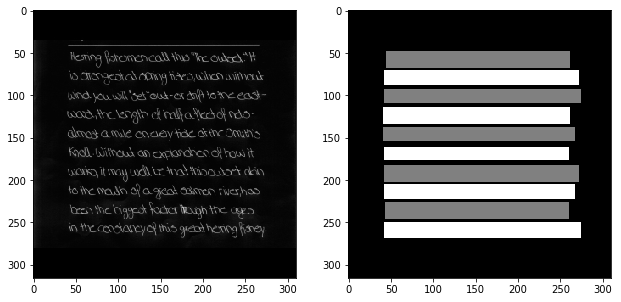

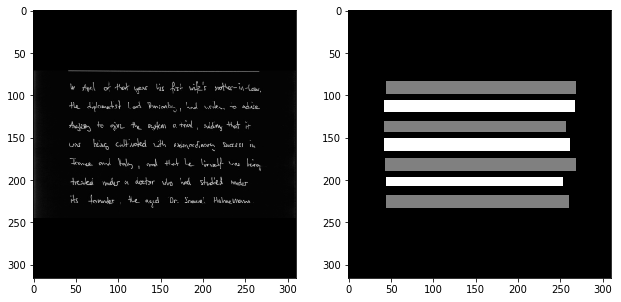

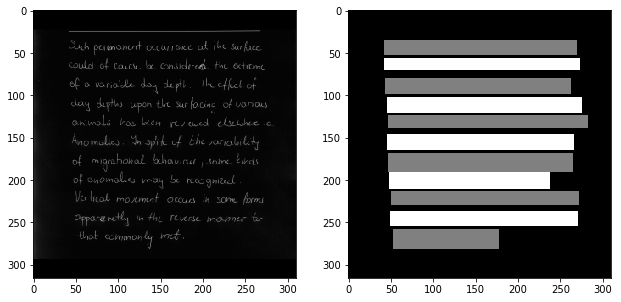

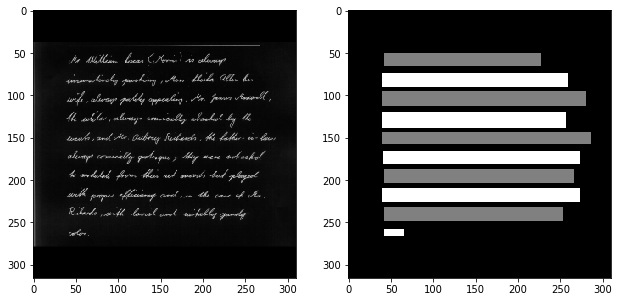

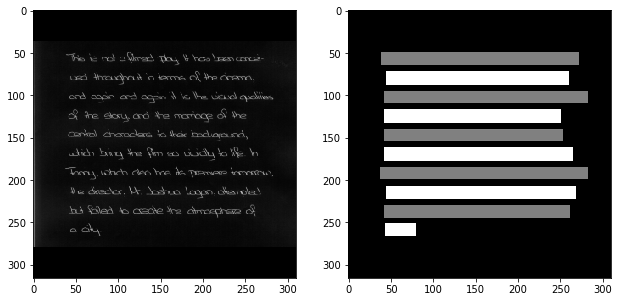

In [5]:
num_plot = 5

for i in np.random.randint(0, X_all.shape[0], num_plot):
    if not PREDICT_ALTERNATING_LINES:
        hplot(X_all[i], Y_all[i])
    else:
        hplot(X_all[i], np.argmax(Y_all[i], axis=-1))

In [6]:
MAX_HEIGHT, MAX_WIDTH = X_all.shape[1:-1]
MAX_HEIGHT, MAX_WIDTH

(316, 310)

In [7]:
base_model_dirname = './_models'
!mkdir -p {base_model_dirname}

identifier = utils.generate_unique_identifier(dirname_with_identifiers=base_model_dirname)

model_dirname = f'{base_model_dirname}/{identifier}'
checkpoints_dirname = f'{model_dirname}/_checkpoints'

!mkdir -p {model_dirname}
!mkdir -p {checkpoints_dirname}

model_dirname

'./_models/kpfrc1pb'

In [8]:
from typing import Tuple
from tensorflow.keras.utils import Sequence
import data_augmentations as augmentations

data_augmentation_params = {
    'width_shift_range': 0.06,
    'height_shift_range': 0.1,
    'horizontal_flip': True,
    'zoom_range': 0.1,
    'fill_mode': 'constant',
    'cval': 0,
    'shear_range': 3,
#     'rotation_range': 2,
#     'vertical_flip': True, - this is a problem for even number of lines.
}


def random_intensity_transformations(image: np.ndarray) -> np.ndarray:
    """Randomly apply one of the image intensity transformations on the image."""
    transformation_functions = [
        augmentations.noop,
        augmentations.random_intensity_stretch,
        augmentations.random_intensity_shrink,
        augmentations.random_adaptive_histogram_equalization,
        augmentations.random_gamma_correction,
        augmentations.random_logarithmic_correction,
        augmentations.sigmoid_correction,
    ]
    function = np.random.choice(transformation_functions)
    return function(image).astype('float32')


def shuffle(X, Y):
    shuffled_indices = np.random.permutation(X.shape[0])
    return X[shuffled_indices], Y[shuffled_indices]


class DataGenerator(Sequence):
    def __init__(self, X: np.ndarray, Y: np.ndarray, batch_size:int, augment: bool, verbose: bool=False):
        if not PREDICT_ALTERNATING_LINES:
            assert X.shape == Y.shape
        if X.ndim == 4:
            self.X = X
            self.Y = Y
        elif X.ndim == 3:
            self.X = np.expand_dims(X, axis=-1)
            self.Y = np.expand_dims(Y, axis=-1)
        else:
            assert False
        self.batch_size = batch_size
        self.augment = augment
        self.verbose = verbose
        self.num_batches = int(np.ceil(len(X) / self.batch_size))
        self.data_augmentor = ImageDataGenerator(**data_augmentation_params)

    def __log__(self, text: str) -> None:
        if self.verbose:
            print(text)

    def __len__(self) -> int:
        self.__log__(f'Number of batches: {self.num_batches}')
        return self.num_batches

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        self.__log__(f'Enter __getitem__() idx: {idx}')
        X_batch = self.X[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        Y_batch = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size].copy()

        if self.augment:
            X_batch, Y_batch = self.augment_data(X_batch, Y_batch)
            X_batch, Y_batch = shuffle(X_batch, Y_batch)
            assert len(np.unique(Y_batch)) == 2

        if FLATTEN_TARGET:
            Y_batch = Y_batch.reshape(Y_batch.shape[0], -1)

        self.__log__(f'Exit __getitem__() idx: {idx}, X: {X_batch.shape}, Y: {Y_batch.shape}')
        return X_batch, Y_batch

    def augment_data(self, X, Y):
        X_aug, Y_aug = zip(*[self._augment_data(x, y) for x, y in zip(X, Y)])
        return np.stack(X_aug, axis=0), np.stack(Y_aug, axis=0)

    def _augment_data(self, x, y):
        transform_parameters = self.data_augmentor.get_random_transform(x.shape)
        x_aug = self.data_augmentor.apply_transform(x, transform_parameters)
        y_aug = self.data_augmentor.apply_transform(y, transform_parameters)

        x_aug = random_intensity_transformations(x_aug)
        return x_aug, y_aug
    
    def on_epoch_end(self) -> None:
        """
        Shuffle all submissions in the dataframe so that the model does not see the same set of submissions
        (shuffled or not) in a step of any epoch.
        """
        self.X, self.Y = shuffle(self.X, self.Y)

### Test data generator

In [14]:
train_dg = DataGenerator(X=X_train, Y=Y_train, batch_size=5, augment=True)
train_dg.__len__()

200

In [15]:
X, Y = train_dg.__getitem__(0)
X.shape, Y.shape

((5, 316, 310, 1), (5, 316, 310, 3))

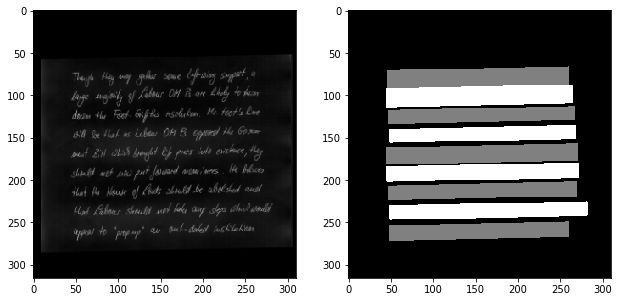

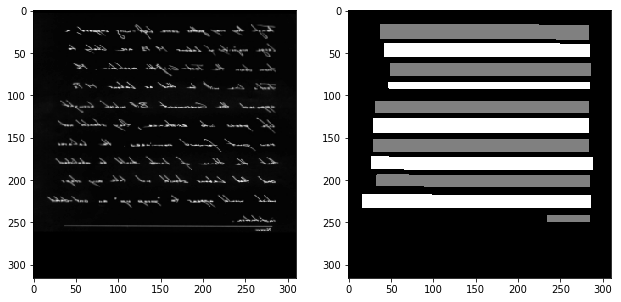

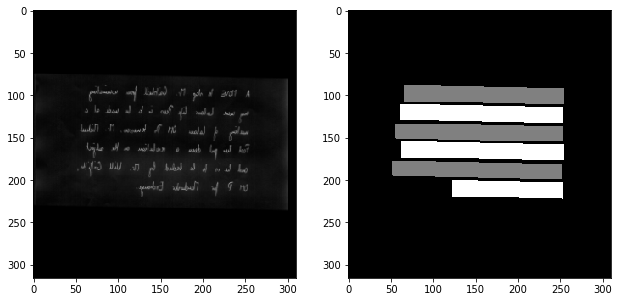

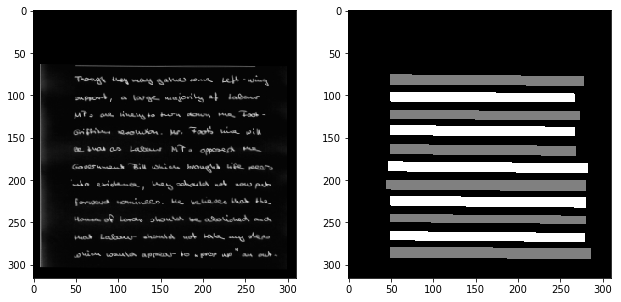

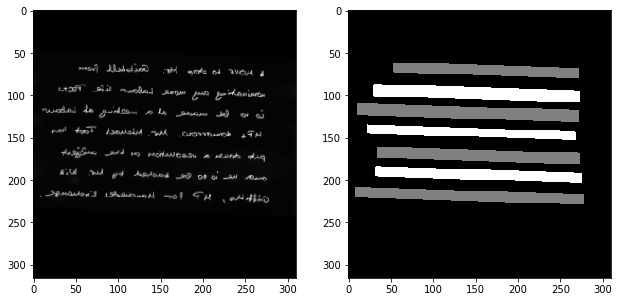

In [16]:
for i in range(5):
    if not PREDICT_ALTERNATING_LINES:
        hplot(X[i], Y[i])
    else:
        hplot(X[i], np.argmax(Y[i], axis=-1))

## Model

In [9]:
batch_size = 32

In [10]:
from typing import List

K.clear_session()  

def conv_block(inputs, num_filters, kernel_size, dilation_rate, activation, batch_norm=False):
    conv = Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, 
                  use_bias=(not batch_norm), padding='same')(inputs)
    if batch_norm:
        conv = BatchNormalization()(conv)
    return Activation(activation)(conv)


def residual_conv_block(input_layer: Layer,
                        kernel_sizes: List[int],
                        num_filters: List[int],
                        dilation_rates: List[int],
                        act: str) -> Layer:
    """Method to instantiate a Residual convolutional block."""
    assert len(num_filters) == 2

    padding = 'same'
    x = Conv2D(num_filters[0], kernel_size=kernel_sizes[0], dilation_rate=dilation_rates[0], 
               padding=padding, activation=act)(input_layer)
    x = Conv2D(num_filters[1], kernel_size=kernel_sizes[1], dilation_rate=dilation_rates[1], padding=padding)(x)
    y = Conv2D(num_filters[1], kernel_size=1, dilation_rate=1, padding=padding)(input_layer)
    x = Add()([x, y])
    x = Activation(act)(x)
    return x

num_filters = [16] * 14
kernel_sizes = [7] * 14
dilation_rates = [3] * 4 + [7] * 10

input_image = Input((MAX_HEIGHT, MAX_WIDTH, 1))

model_layer = input_image
for i in range(0, len(num_filters), 2):
    model_layer = residual_conv_block(input_layer=model_layer, 
                                      kernel_sizes=kernel_sizes[i:i+2], 
                                      num_filters=num_filters[i:i+2], 
                                      dilation_rates=dilation_rates[i:i+2], 
                                      act='relu')
if not PREDICT_ALTERNATING_LINES:
    output = conv_block(model_layer, 1, 1, 1, 'sigmoid')
else:
    output = conv_block(model_layer, 3, 1, 1, 'softmax')    

if FLATTEN_TARGET:
    output = Flatten()(output)
model = Model(inputs=input_image, outputs=output)
model.summary()

if not PREDICT_ALTERNATING_LINES:
    model.compile(optimizer=Adam(0.001/2), loss='binary_crossentropy')
else:
    model.compile(optimizer=Adam(0.001/2), loss='categorical_crossentropy')    
    
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25),
    ModelCheckpoint(
            filepath=checkpoints_dirname + "/epoch_{epoch:02d}-val_loss_{val_loss:.4f}.h5",
            monitor='val_loss',
            save_best_only=True
        )
]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 316, 310, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 316, 310, 16) 800         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 316, 310, 16) 12560       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 316, 310, 16) 32          input_1[0][0]                    
__________________________________________________________________________________________________
add (Add) 

In [19]:
%%time 

train_dg = DataGenerator(X=X_train, Y=Y_train, batch_size=batch_size, augment=True)

if FLATTEN_TARGET:
    target = Y_test.reshape(Y_test.shape[0], -1)
else:
    target = Y_test
    
history = model.fit_generator(
    generator=train_dg, 
    epochs=1000,
    validation_data=(X_test, target),
    shuffle=True,
    callbacks=callbacks    
)

Epoch 1/1000


/home/saurabh/.local/share/virtualenvs/pandagrader-2b4G2K8K/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


32/32 [==============================] - 43s 1s/step - loss: 23.5374 - val_loss: 17.1422
Epoch 2/1000
32/32 [==============================] - 38s 1s/step - loss: 16.3993 - val_loss: 14.4258
Epoch 3/1000
32/32 [==============================] - 38s 1s/step - loss: 14.3988 - val_loss: 11.4832
Epoch 4/1000
32/32 [==============================] - 38s 1s/step - loss: 10.6092 - val_loss: 8.9765
Epoch 5/1000
32/32 [==============================] - 39s 1s/step - loss: 8.6962 - val_loss: 1.8575
Epoch 6/1000
32/32 [==============================] - 37s 1s/step - loss: 7.6525 - val_loss: 6.8450
Epoch 7/1000
32/32 [==============================] - 37s 1s/step - loss: 7.0267 - val_loss: 6.1156
Epoch 8/1000
32/32 [==============================] - 37s 1s/step - loss: 6.5986 - val_loss: 5.9780
Epoch 9/1000
32/32 [==============================] - 37s 1s/step - loss: 6.6135 - val_loss: 6.6589
Epoch 10/1000
32/32 [==============================] - 38s 1s/step - loss: 6.2406 - val_loss: 5.5810
Epoch

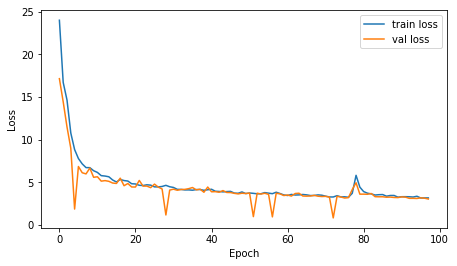

In [20]:
utils.plot_training_history(history.history, metric=None)

## Loading best model

In [21]:
model_filenames = !ls {checkpoints_dirname} -t
best_model_filename = model_filenames[0]

!cp {checkpoints_dirname}/{best_model_filename} {model_dirname}
!rm {checkpoints_dirname}/*
best_model_filename

'epoch_73-val_loss_0.8193.h5'

In [22]:
model.load_weights(f'{model_dirname}/{best_model_filename}')
best_model_filename

'epoch_73-val_loss_0.8193.h5'

## Loading current best model

In [11]:
model.load_weights('models/alternating_line_detection_model.h5')

## Model evaluation

In [12]:
if FLATTEN_TARGET:
    target = Y_test.reshape(Y_test.shape[0], -1)
else:
    target = Y_test
    
model.evaluate(X_test, target, batch_size=batch_size)

537/537 [==============================] - 8s 14ms/step


3.243524654839514

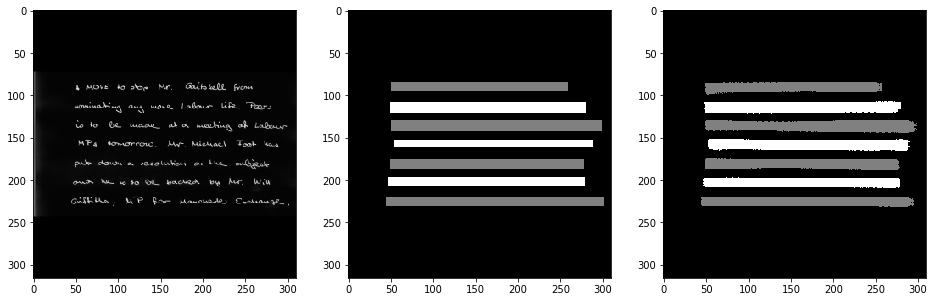

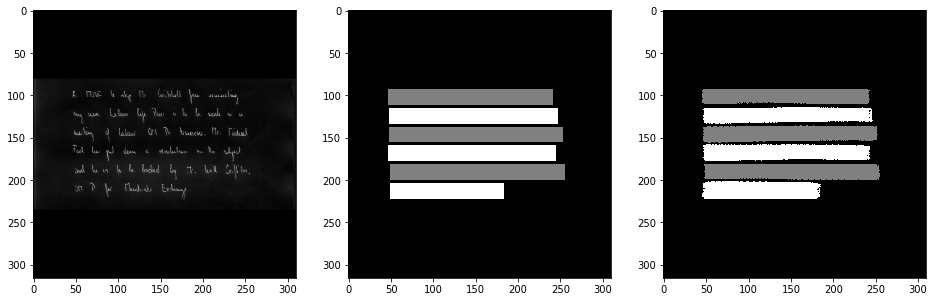

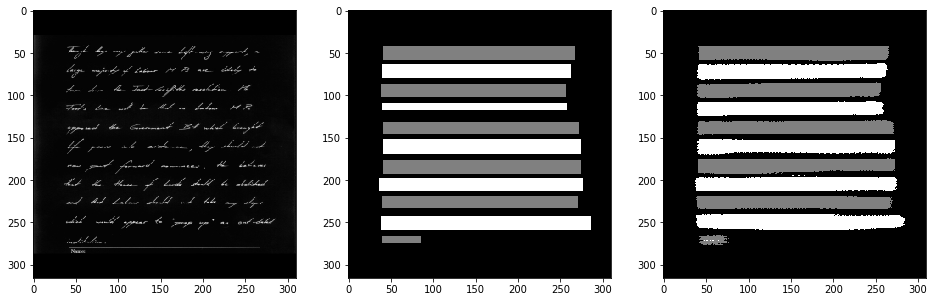

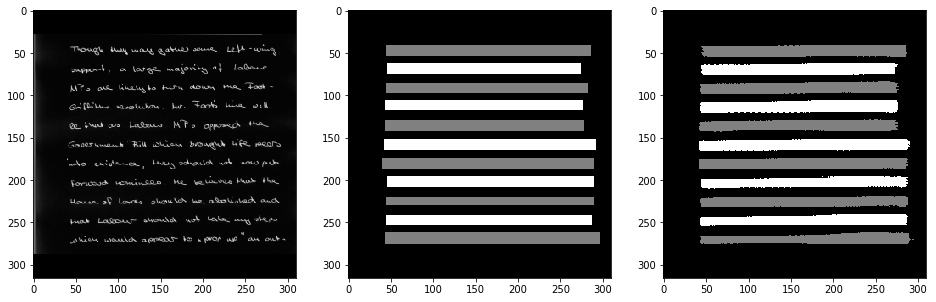

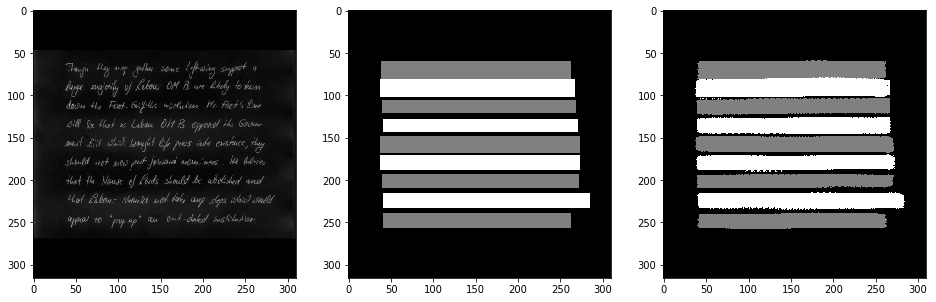

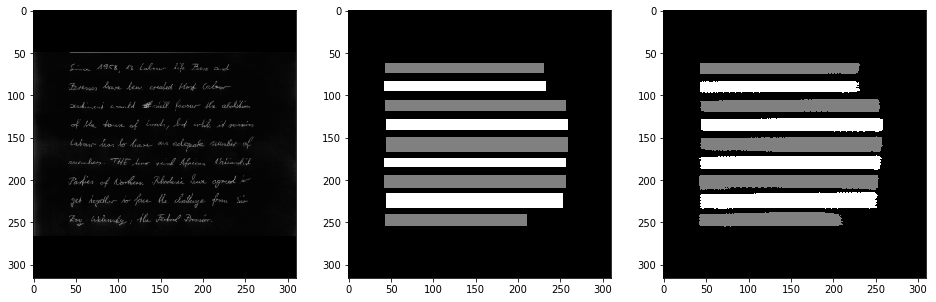

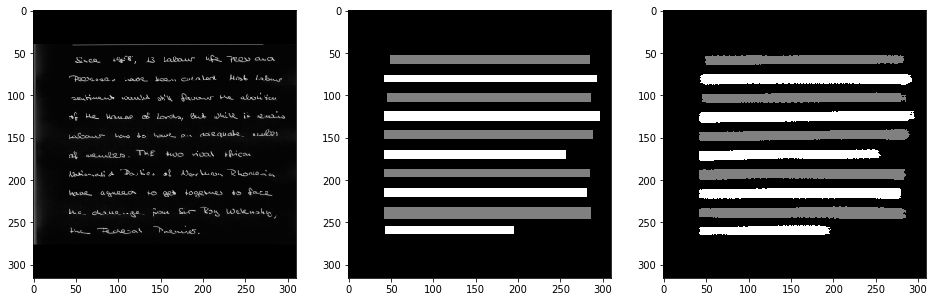

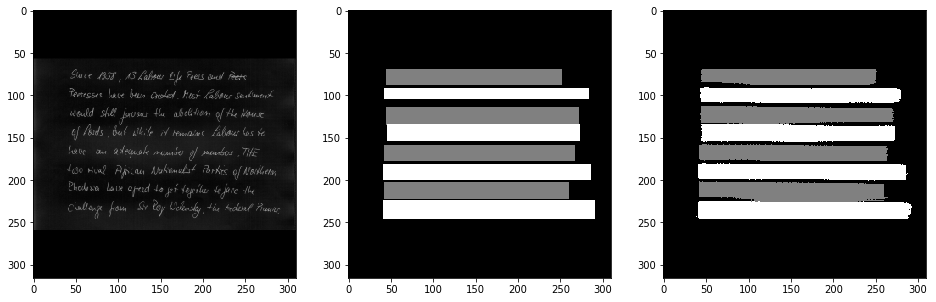

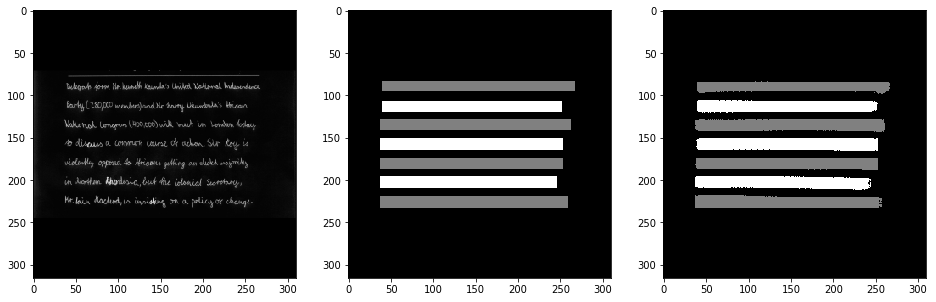

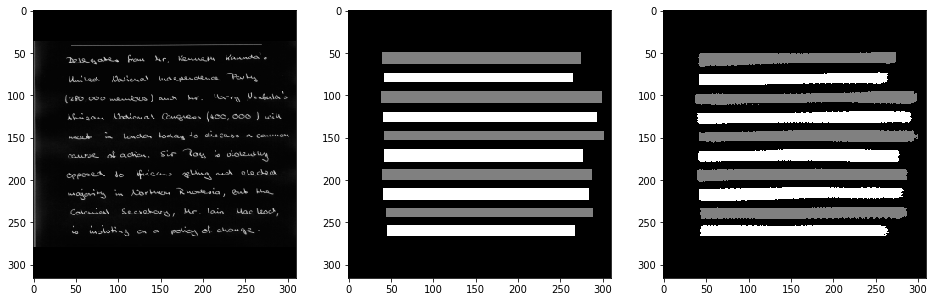

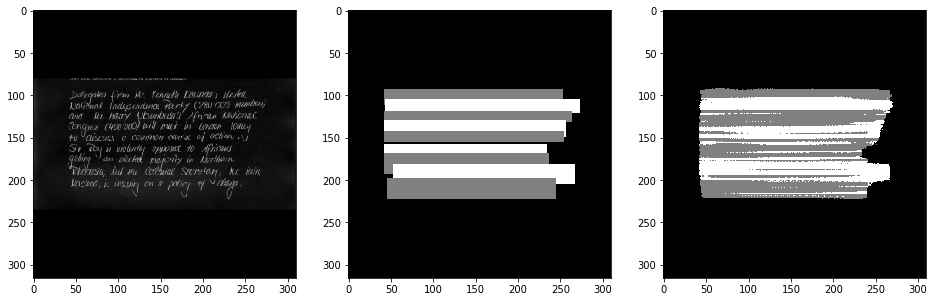

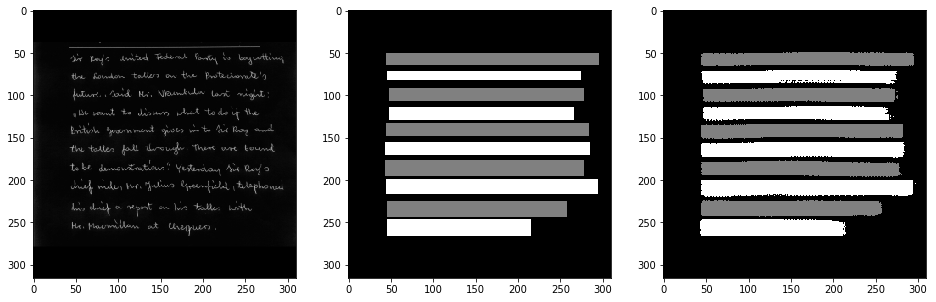

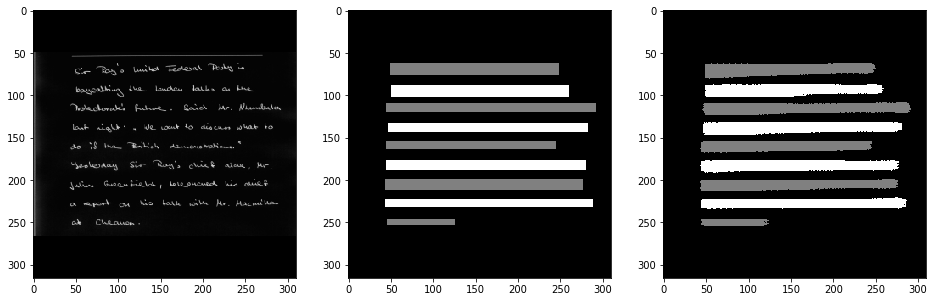

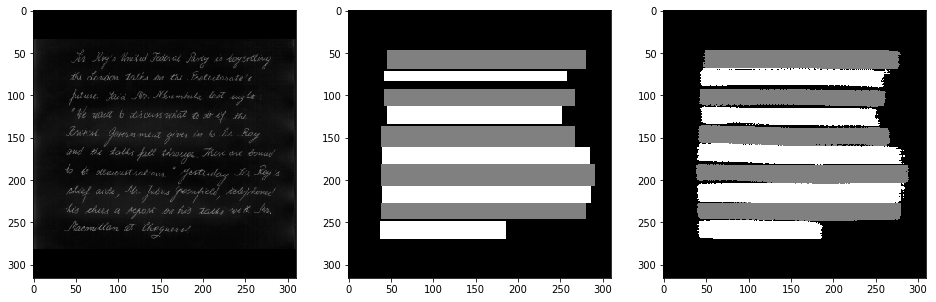

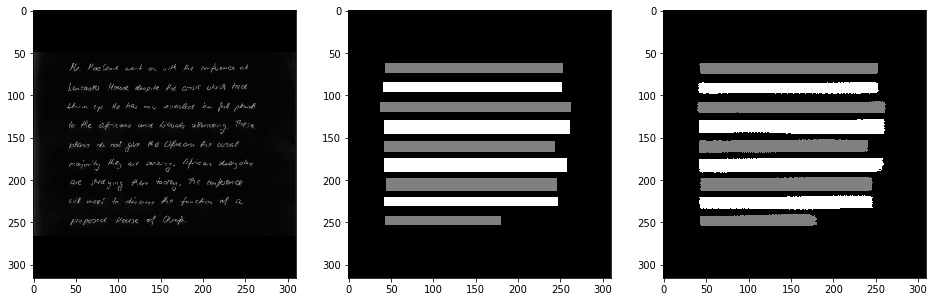

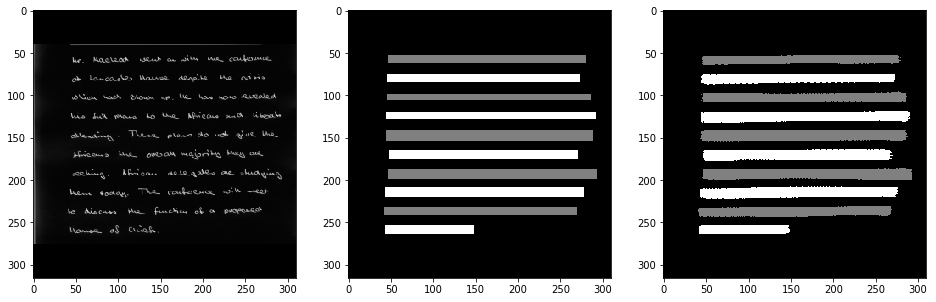

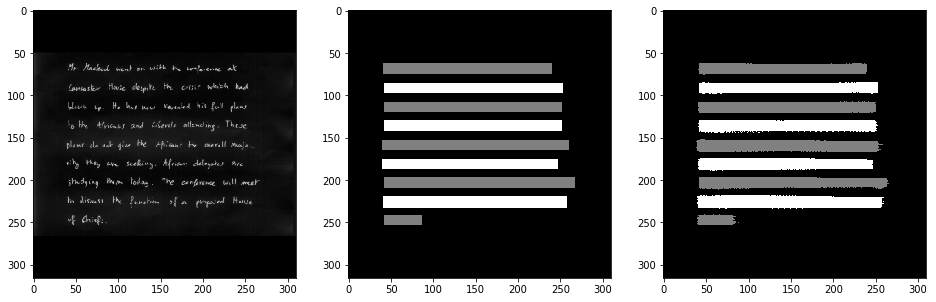

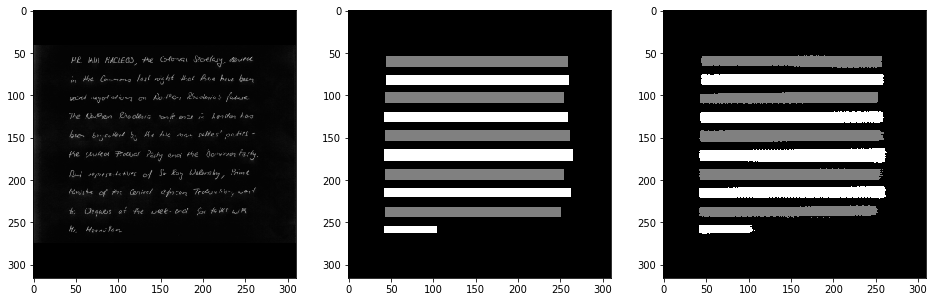

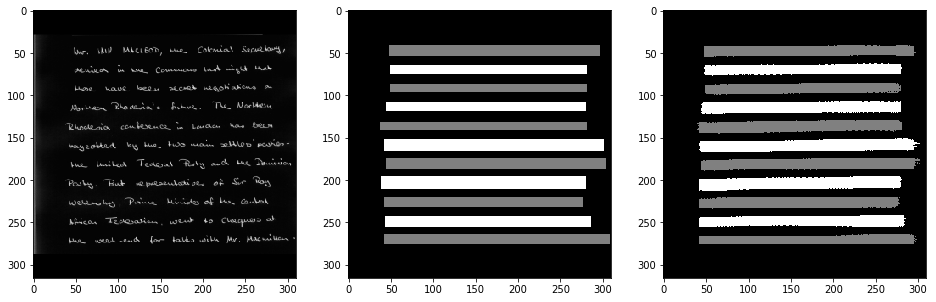

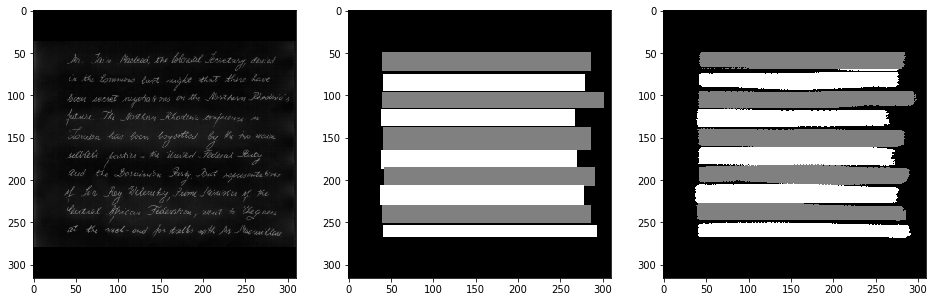

In [13]:
start_id = 0
count = 20

X = X_train[start_id:start_id+count]
Y = Y_train[start_id:start_id+count]

Y_pred = model.predict(X)
for x, y, y_pred in zip(X, Y, Y_pred):
    if not PREDICT_ALTERNATING_LINES:
        hplot(x, y, y_pred)
    else:
        hplot(x, np.argmax(y, axis=-1), np.argmax(y_pred, axis=-1))

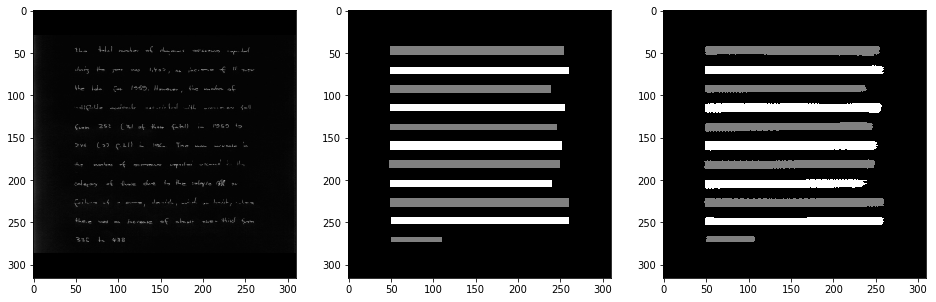

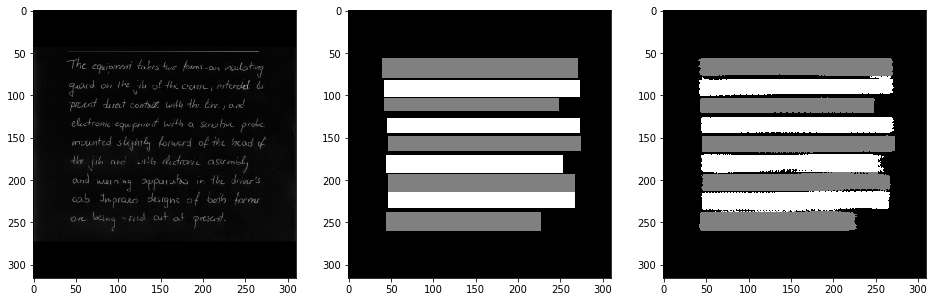

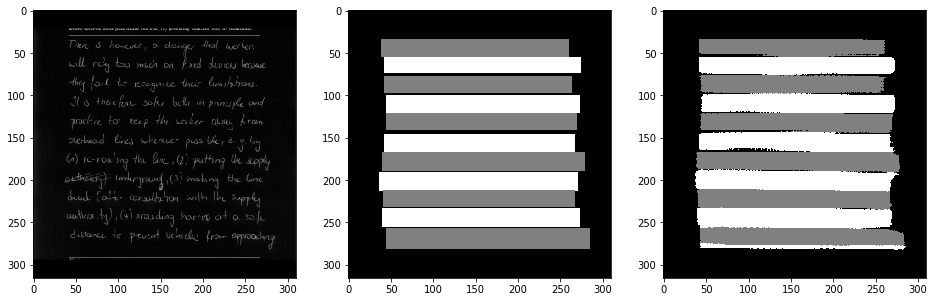

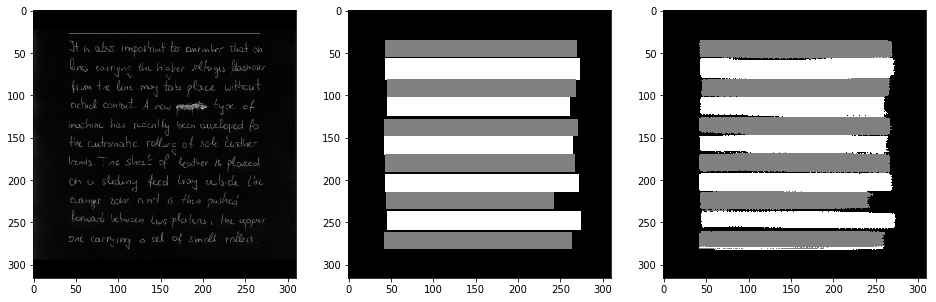

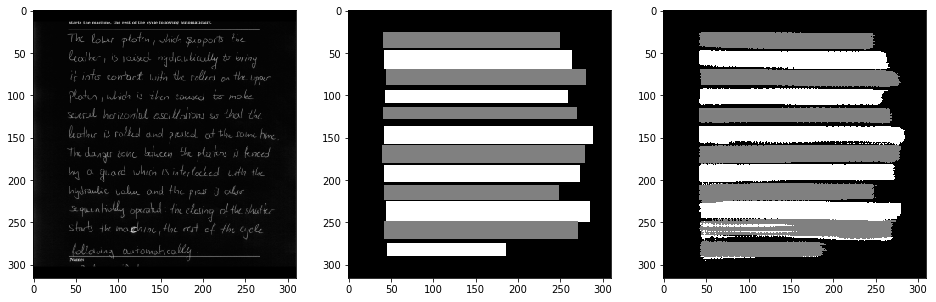

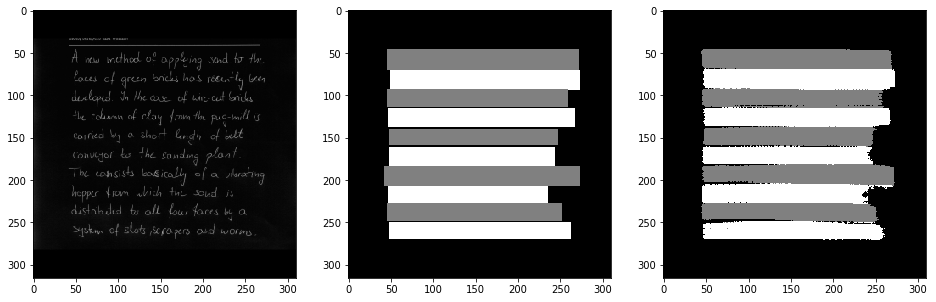

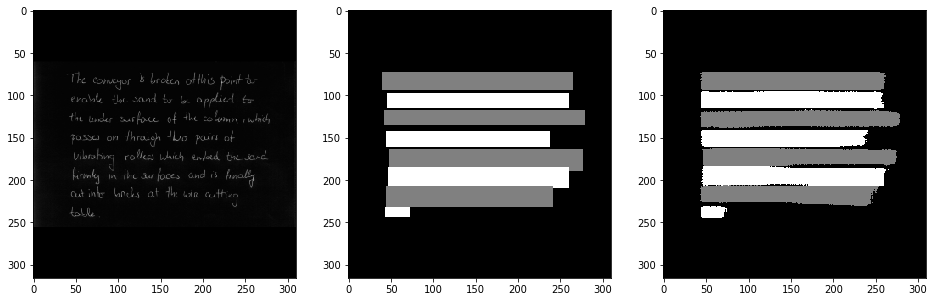

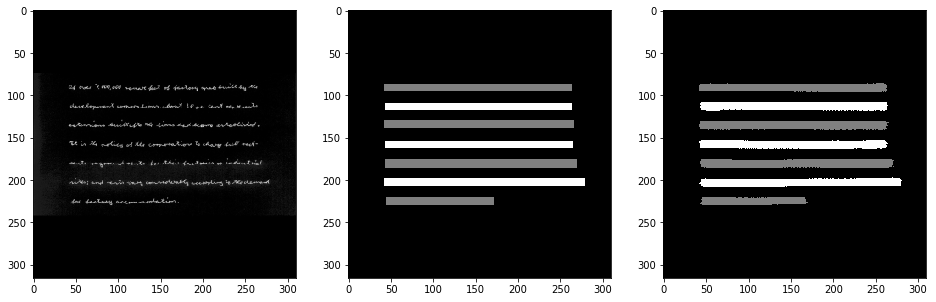

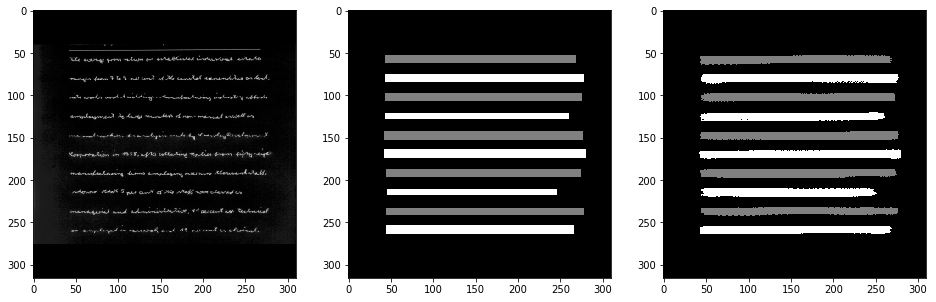

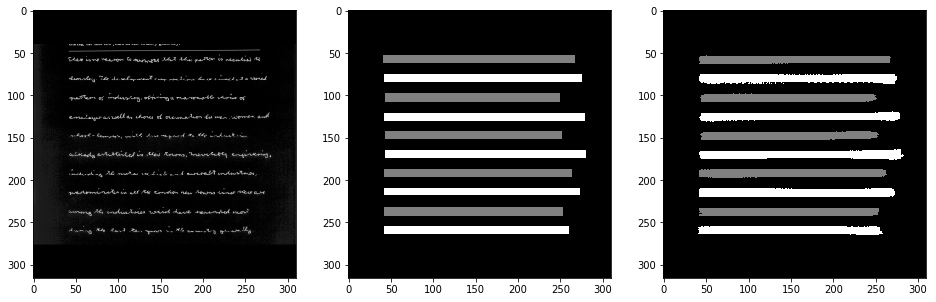

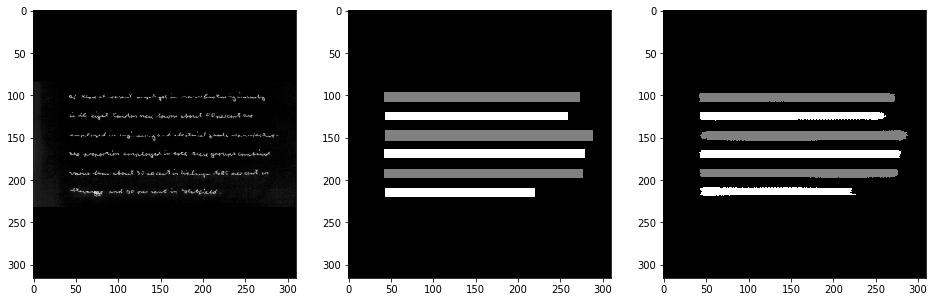

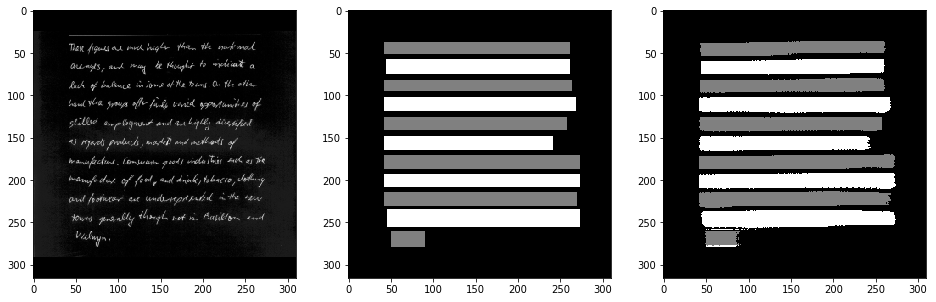

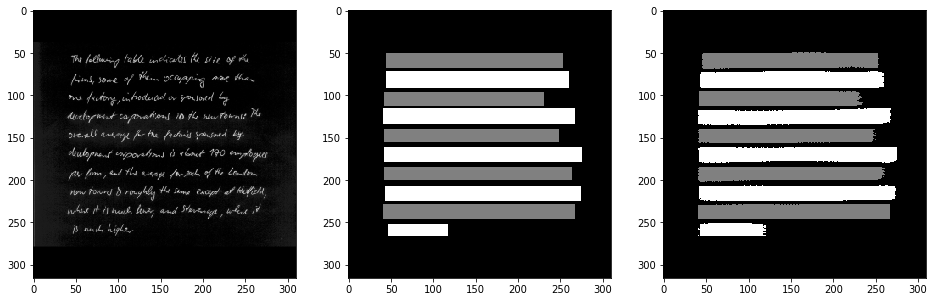

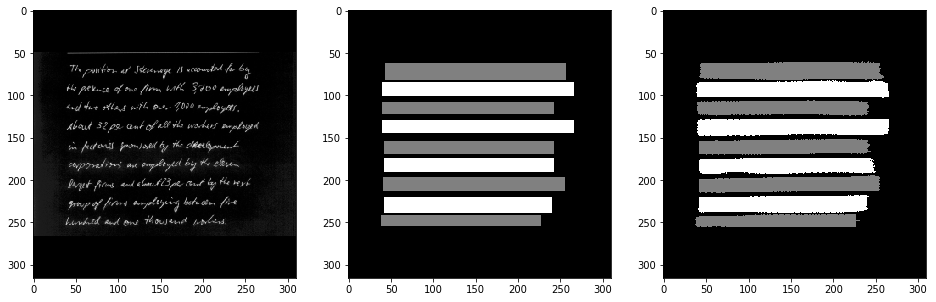

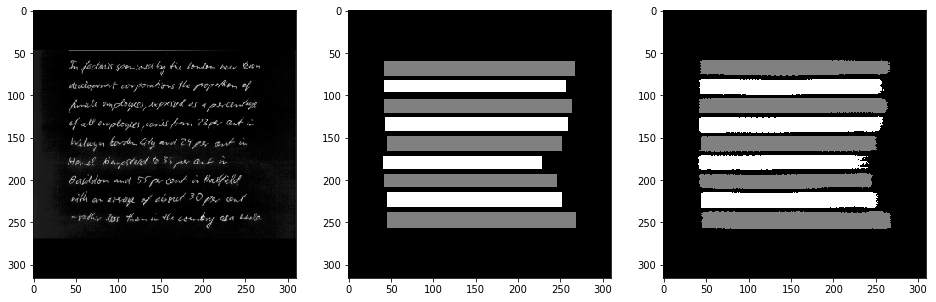

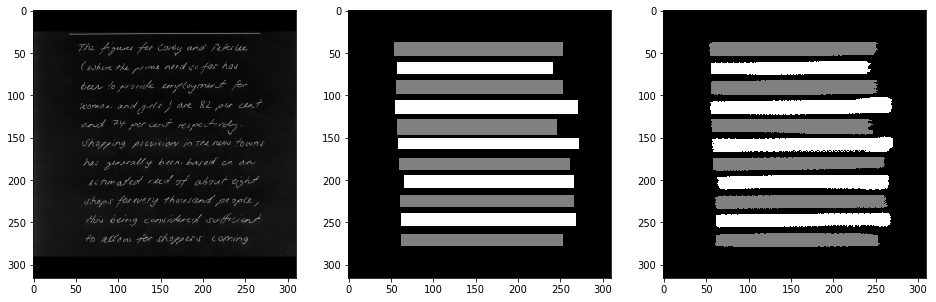

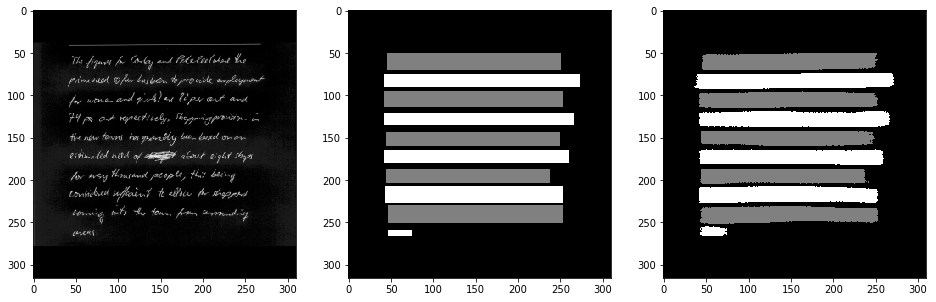

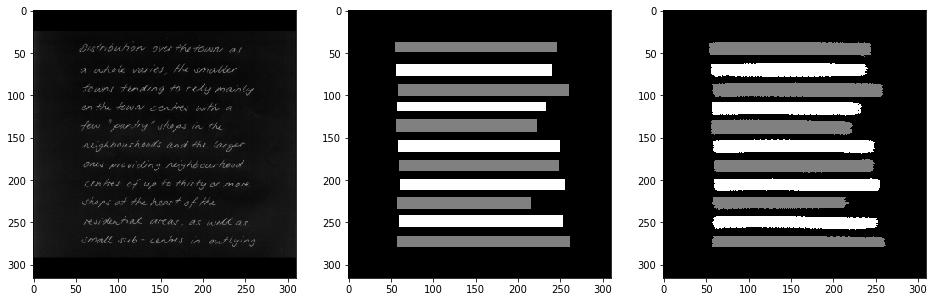

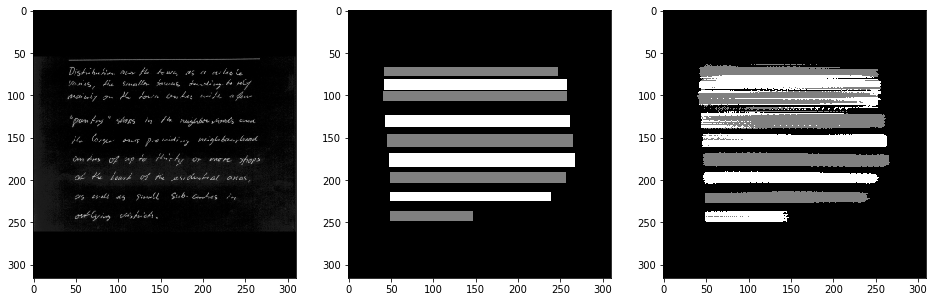

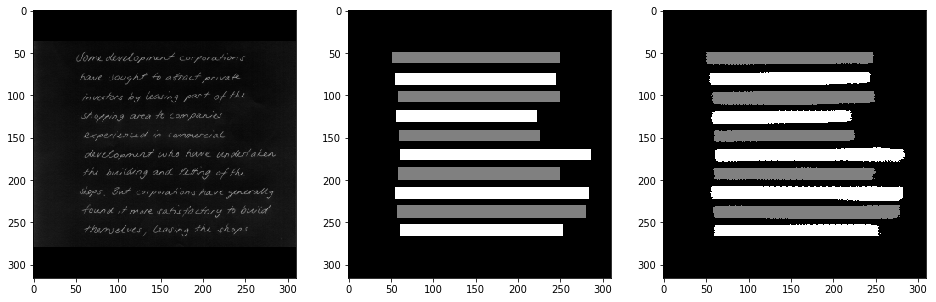

In [14]:
start_id = 0
count = 20

X = X_test[start_id:start_id+count]
Y = Y_test[start_id:start_id+count]

Y_pred = model.predict(X)
for x, y, y_pred in zip(X, Y, Y_pred):
    if not PREDICT_ALTERNATING_LINES:
        hplot(x, y, y_pred)
    else:
        hplot(x, np.argmax(y, axis=-1), np.argmax(y_pred, axis=-1))